In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import random
nltk.download('punkt')
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split
nltk.download('stopwords')
from itertools import chain

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
data = pd.read_csv('BBB.csv')
data.head(10)

,Topic,Paragraph
0,A Monument for Peace,"In December, 1864, the Civil War was nearly ov..."
1,The Brooklyn Bridge,Have you ever seen a picture of the Brooklyn B...
2,Pluto: The Planet That Wasn't,Poor Pluto!\n\nIt’s bad enough to be the runt ...
3,When Television Became Colorful,"Today, nearly all television programs are broa..."
4,An Unlikely Parasite: The Mistletoe,"During the holidays, many people hang mistleto..."
5,Predicting the Future,"Garry Golden sits in a small cafe in Brooklyn,..."
6,Benjamin Franklin: The Ultimate Solution Creator,Benjamin Franklin is credited with an array of...
7,Alexander Graham Bel,"Alexander Graham Bell was in his laboratory, w..."
8,Louis Braille,Have you ever noticed when you step into an el...
9,The Origins of the Internet,All of the men were nervous as they waited. Bu...


In [0]:
data=data.fillna(0)

In [0]:
def remove_stop_punct_from_paragrapghs(par):
  tokenizer = RegexpTokenizer(r'\w+')
  tokens = tokenizer.tokenize(str(par).lower())
  stop_words = set(stopwords.words('english'))
  tokens = [w for w in tokens if not w in stop_words]
  new_par= tokens
  return new_par

In [0]:
def remove_stop_from_questions(que):
  tokenizer = RegexpTokenizer(r'\w+')
  tokens = tokenizer.tokenize(str(que).lower())
  stop_words = set(stopwords.words('english'))
  tokens = [w for w in tokens if w in word_corpus if not w in stop_words]
  new_que = tokens
  return new_que


In [0]:
def Create_Paragraph_Topic_list(data):
  temp=[]
  row_data=[]
  for i in range(data.shape[0]):
    for j in tokenize.sent_tokenize(data['Paragraph'][i]):
      temp.append((j,data['Paragraph'][i],data['Topic'][i]))
  temp
  for ele in temp:
    if ele[0]!=0:
      row_data.append(ele)
  return row_data
row_data = Create_Paragraph_Topic_list(data)

In [0]:
def Creat_X(data):
  C=Create_Paragraph_Topic_list(data)
  sentence_list=[]
  for i in range((len(C))):
    sentence_list.append(remove_stop_from_questions(C[i][0]))
  return sentence_list


In [0]:
def Creat_Y(data):
  row_data = Create_Paragraph_Topic_list(data)
  paragraph_list=[]
  for i in range((len(row_data))):
    paragraph_list.append(remove_stop_punct_from_paragrapghs(row_data[i][1]))
  return paragraph_list


In [0]:
def creat_word_corpus(data):
  par=Creat_Y(data)
  #word_corpus=creat_word_corpus(par)
  word_corpus= np.unique(np.array(list(chain.from_iterable(par))))
  return word_corpus
word_corpus=creat_word_corpus(data)

In [0]:
X = Creat_X(data)
Y = Creat_Y(data)


In [0]:
def gen_voc(w):
  voc = {ch:i for i ,ch in enumerate(w)}
  return voc
voc =gen_voc(word_corpus)

In [0]:
def multi_hot_encode(sequences, dimension):
  results=np.zeros((len(sequences), dimension))
  for i in range(len(sequences)):
    for j in sequences[i]:
      results[i][voc[j]]=1
  return results

In [0]:
x = multi_hot_encode(X, word_corpus.shape[0])
y = multi_hot_encode(Y, word_corpus.shape[0])

In [0]:
dict1={}
for i in range(y.shape[0]):
  dict1.update( {row_data[i][2] :y[i]} )


In [0]:
from sklearn.tree import DecisionTreeClassifier
dtc =DecisionTreeClassifier()
dtc.fit(x, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [0]:
def quen_test(Q,dict1):
  q=np.array([Q])
  q=q.reshape(1,-1)
  q=remove_stop_from_questions(q)
  q_test =  multi_hot_encode([q], word_corpus.shape[0])
  ans= dtc.predict(q_test)
  for key , value in dict1.items():
    if (value==ans).all():
      break
  return key

In [0]:
Q='What type of TV companies would sell?'
quen_test(Q,dict1)

'When Television Became Colorful'

In [0]:
question = pd.read_csv('questions.csv')
question.head()

,Questions,A,B,C,D,Answer
0,What type of TV companies would sell?,Good Quality,Low resolution,Flicker picture,Less responsive,A
1,What was the cost of the original statue in 1...,"$15,000","$10,000","$20,000","$30,000",D
2,In which year Mrs. James E. Caldwell and her g...,1814,1714,1914,1924,C
3,What Scientists made new rules and decide to ...,Only Pluto qualified,Only Eris qualified,Both Pluto and Eris qualified,neither Pluto nor Eris qualified,D
4,When it is unusual to find any television show...,past decades,Today,In 1992,None of the above,B


In [0]:
def update_flag(sugst_list,s_value):
  B = list(sugst_list.items())
  C=sorted(B,key=lambda x: x[1], reverse=False)
  simp=[]
  for i in range(s_value):
    simp.append(C[i][0])
  return simp

In [0]:
def Start_Quiz(number_of_questions=10,s_value=2,mpq=1,negmark=0.25):
  right_que = 0
  wrong_que = 0
  count_que = 1
  nn = number_of_questions
  l=[]
  t_name=[]
  s = (list(np.linspace(0,(question.shape[0]-1),question.shape[0],endpoint=True,dtype=int)))
  
  sugst_list = {ch:0 for i ,ch in enumerate(data['Topic'])}
  while(number_of_questions>0):
    simplicity =update_flag(sugst_list,s_value)
    random.shuffle(s)
    if quen_test(question['Questions'][s[0]],dict1) not in simplicity:
      print('\n')
      print('\n')
      print(count_que,':',question['Questions'][s[0]],'\n','a)',question['A'][s[0]],'\n','b)',question['B'][s[0]],'\n','c)',question['C'][s[0]],'\n','d)',question['D'][s[0]],'\n','*FOR SKIP PRESS ENTER')
      print('\n')
      ans = input("Make your choice : ")
      
      
      if ans.upper() == question['Answer'][s[0]]:
          print("Correct!! \U0001F44D")
          Y_predict = quen_test(question['Questions'][s[0]],dict1)
          l.append((Y_predict,1))
          t_name.append(Y_predict)
          sugst_list[Y_predict] = sugst_list[Y_predict]+1
          right_que+=1
      elif ans.upper() =="":
        Y_predict = quen_test(question['Questions'][s[0]],dict1)
        t_name.append(Y_predict)  
        
        
      else:
          print(" Your answer is Incorrect!! \U0001F44E	 ",'\n',"Correct option is:",question['Answer'][s[0]].lower()) 
          Y_predict = quen_test(question['Questions'][s[0]],dict1)
          l.append((Y_predict,0))
          t_name.append(Y_predict)
          sugst_list[Y_predict] = sugst_list[Y_predict]-1
          wrong_que+=1
        
      
        
        
      number_of_questions=number_of_questions-1
      s.remove(s[0])
      count_que+=1
      
    else:
      random.shuffle(s) 
          
  u_list=list(set(t_name))
  l_wrong=[]
  for i in range(len(l)):
    if l[i][1]==0:
      l_wrong.append(l[i][0])
  l_right=[]
  for i in range(len(l)):
    if l[i][1]==1:
      l_right.append(l[i][0])
  std_list=[]
  for i in range(len(l)):
      std_list.append((l[i][0],l_right.count(l[i][0]),l_wrong.count(l[i][0])))
  p =list(set(std_list))
  res = []
  only_prob=[]
  for i in range(len(p)):
    res.append((p[i][0],round(p[i][1]*100/(p[i][1]+p[i][2]),2)))
    only_prob.append(round(p[i][1]*100/(p[i][1]+p[i][2]),2))
  summary=pd.DataFrame(res,columns=['Topic', 'Percent(Right)'])
  only_prob=np.sort(only_prob)
  score_f = (right_que-wrong_que*negmark)*mpq
 
  
  return summary , right_que, wrong_que ,score_f,nn,only_prob

In [0]:
summary , right_que, wrong_que ,score_f,nn,only_prob= Start_Quiz(15)





1 : What type of TV companies would  sell? 
 a) Good Quality 
 b) Low resolution 
 c) Flicker picture 
 d) Less responsive 
 *FOR SKIP PRESS ENTER


Make your choice : a
Correct!! 👍




2 : The article describes a sequence of events in the history of the color television. Which of these events happened first? 
 a) Most people in the U.S. bought color television sets. 
 b) Most television shows began to be broadcast in color. 
 c) People worked to make the picture on color television sets clearer. 
 d) Television programs were broadcast in black and white only. 
 *FOR SKIP PRESS ENTER


Make your choice : 




3 : What is one positive effect mistletoes have on the ecosystems where they grow? 
 a) They take water and nutrients away from plants. 
 b) They have leaves that remain green throughout the year 
 c) They provide food to some animals. 
 d) They have seeds which can grow roots into the barks of trees and shrubs. 
 *FOR SKIP PRESS ENTER


Make your choice : 




4 : What is thi


------------------------Score---------------------------
Number of right question :  8
Number of wrong question :  5
     Your Total score is :  45.0 %
---------------FINAL SUMMARY--------------------


,Topic,Percent(Right)
0,Alexander Graham Bel,100.0
1,A Monument for Peace,0.0
2,Benjamin Franklin: The Ultimate Solution Creator,50.0
3,Louis Braille,0.0
4,When Television Became Colorful,100.0
5,The Brooklyn Bridge,0.0
6,Pluto: The Planet That Wasn't,100.0


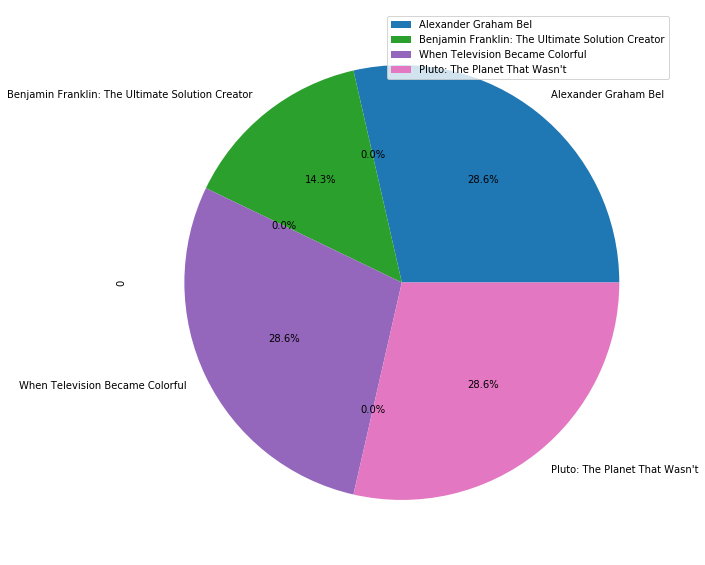

In [0]:
def Score(summary , right_que, wrong_que ,score_f,nn,only_prob):
  print()
  print('------------------------Score---------------------------')
  print("Number of right question : ",right_que)
  print("Number of wrong question : ",wrong_que)
  print("     Your Total score is : ",round((score_f*100)/nn,2),'%')
  #print('You need to highly revise again :->',list(fres[fres['Percent(Right)']==only_prob[0]]['Topic'])[0])
  #print('And also focus on :->',list(fres[fres['Percent(Right)']==only_prob[1]]['Topic'])[0])
  print('---------------FINAL SUMMARY--------------------')
  
  df = pd.DataFrame(list(np.array(summary['Percent(Right)'])), index=list(np.array(summary['Topic'])))

  df.plot(kind='pie',autopct='%1.1f%%', subplots=True, figsize=(10, 10))

  return summary
Score(summary , right_que, wrong_que ,score_f,nn,only_prob)